# 导入工具包

In [1]:
import warnings
warnings.filterwarnings('ignore')
import argparse
import numpy as np
import networkx as nx
from gensim.models import Word2Vec
import random

import matplotlib.pyplot as plt
%matplotlib inline

# 读入命令行参数

In [19]:
def parse_args():
    # 使用parser加载信息
    parser = argparse.ArgumentParser(description="Run node2vec.")

    parser.add_argument('--input', nargs='?', default='data/karate.edgelist',
                        help='Input graph path')

    parser.add_argument('--output', nargs='?', default='data/karate.emb',
                        help='Embeddings path')

    parser.add_argument('--dimensions', type=int, default=128,
                        help='Number of dimensions. Default is 128.')

    parser.add_argument('--walk-length', type=int, default=80,
                        help='Length of walk per source. Default is 80.')

    parser.add_argument('--num-walks', type=int, default=10,
                        help='Number of walks per source. Default is 10.')

    parser.add_argument('--window-size', type=int, default=10,
                        help='Context size for optimization. Default is 10.')

    parser.add_argument('--iter', default=1, type=int,
                          help='Number of epochs in SGD')

    parser.add_argument('--workers', type=int, default=8,
                        help='Number of parallel workers. Default is 8.')

    parser.add_argument('--p', type=float, default=1,
                        help='Return hyperparameter. Default is 1.')

    parser.add_argument('--q', type=float, default=2,
                        help='Inout hyperparameter. Default is 2.')

    parser.add_argument('--weighted', dest='weighted', action='store_true',
                        help='Boolean specifying (un)weighted. Default is unweighted.')
    parser.add_argument('--unweighted', dest='unweighted', action='store_false')
    parser.set_defaults(weighted=False)

    parser.add_argument('--directed', dest='directed', action='store_true',
                        help='Graph is (un)directed. Default is undirected.')
    parser.add_argument('--undirected', dest='undirected', action='store_false')
    parser.set_defaults(directed=False)

    return parser.parse_known_args(args=[])

args = parse_args()[0]

In [20]:
args

Namespace(input='data/karate.edgelist', output='data/karate.emb', dimensions=128, walk_length=80, num_walks=10, window_size=10, iter=1, workers=8, p=1, q=2, weighted=False, unweighted=True, directed=False, undirected=True)

# 载入图

In [22]:
if args.weighted:
    G = nx.read_edgelist(args.input, nodetype=int, data=(('weight', float),), create_using=nx.DiGraph())
else:
    G = nx.read_edgelist(args.input, nodetype=int, create_using=nx.DiGraph())
    for edge in G.edges():
        G[edge[0]][edge[1]]['weight'] = np.abs(np.random.randn())
        
if not args.directed:
    G = G.to_undirected()

In [23]:
len(G)

34

In [24]:
G.nodes

NodeView((1, 32, 22, 20, 18, 14, 13, 12, 11, 9, 8, 7, 6, 5, 4, 3, 2, 31, 10, 33, 29, 28, 17, 34, 15, 16, 19, 21, 23, 24, 30, 26, 25, 27))

In [25]:
G.edges

EdgeView([(1, 32), (1, 22), (1, 20), (1, 18), (1, 14), (1, 13), (1, 12), (1, 11), (1, 9), (1, 8), (1, 7), (1, 6), (1, 5), (1, 4), (1, 3), (1, 2), (32, 34), (32, 33), (32, 29), (32, 26), (32, 25), (22, 2), (20, 34), (20, 2), (18, 2), (14, 34), (14, 4), (14, 3), (14, 2), (13, 4), (11, 6), (11, 5), (9, 34), (9, 33), (9, 3), (8, 4), (8, 3), (8, 2), (7, 17), (7, 6), (7, 5), (6, 17), (4, 3), (4, 2), (3, 10), (3, 33), (3, 29), (3, 28), (3, 2), (2, 31), (31, 34), (31, 33), (10, 34), (33, 34), (33, 15), (33, 16), (33, 19), (33, 21), (33, 23), (33, 24), (33, 30), (29, 34), (28, 34), (28, 24), (28, 25), (34, 15), (34, 16), (34, 19), (34, 21), (34, 23), (34, 24), (34, 30), (34, 27), (24, 30), (24, 26), (30, 27), (26, 25)])

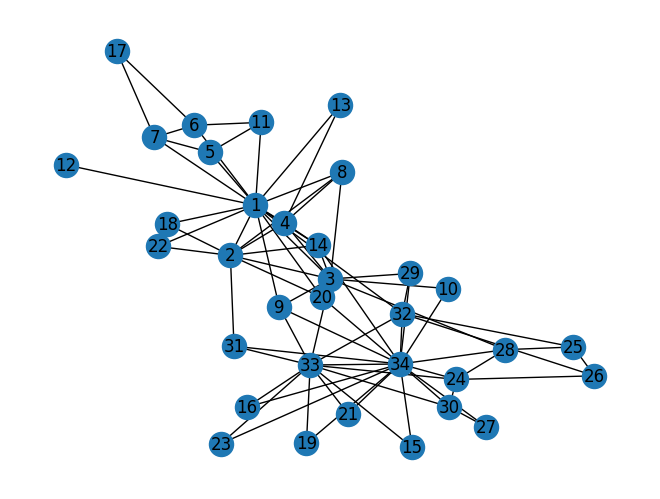

In [26]:
pos = nx.spring_layout(G, seed=1)
nx.draw(G, pos, with_labels=True)
plt.show()

Alias

In [31]:
def alias_setup(probs):
    '''
    Compute utility lists for non-uniform sampling from discrete distributions.
    Refer to https://hips.seas.harvard.edu/blog/2013/03/03/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
    for details
    '''
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=np.int32)

    smaller = []
    larger = []
    for kk, prob in enumerate(probs):
        q[kk] = K*prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

In [32]:
def alias_draw(J, q):
    '''
    Draw sample from a non-uniform discrete distribution using alias sampling.
    '''
    K = len(J)

    kk = int(np.floor(np.random.rand()*K))
    if np.random.rand() < q[kk]:
        return kk
    else:
        return J[kk]

In [33]:
def get_alias_edge(src, dst):
    '''
    Get the alias edge setup lists for a given edge.
    '''
    p = args.p
    q = args.q

    unnormalized_probs = []
    for dst_nbr in sorted(G.neighbors(dst)):
        if dst_nbr == src:
            unnormalized_probs.append(G[dst][dst_nbr]['weight']/p)
        elif G.has_edge(dst_nbr, src):
            unnormalized_probs.append(G[dst][dst_nbr]['weight'])
        else:
            unnormalized_probs.append(G[dst][dst_nbr]['weight']/q)
    norm_const = sum(unnormalized_probs)
    normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]

    return alias_setup(normalized_probs)

In [34]:
get_alias_edge(15, 16)

(array([0, 0]), array([1.        , 0.15967381]))

In [35]:
is_directed = args.directed
alias_nodes = {}

for node in G.nodes():
    unnormalized_probs = [G[node][nbr]['weight'] for nbr in sorted(G.neighbors(node))]
    norm_const= sum(unnormalized_probs)
    normalized_probs = [float(u_prob)/norm_const for u_prob in unnormalized_probs]
    alias_nodes[node] = alias_setup(normalized_probs)
    if node == 14:
        print('14号节点')
        print(unnormalized_probs)
        print(norm_const)
        print(normalized_probs)
        print(alias_nodes[node])

14号节点
[1.2534895532050132, 0.21116936524356733, 1.1985646078580294, 1.1075387726096249, 0.27989891668968175]
4.050661215605917
[0.3094530711123691, 0.052132072766292704, 0.29589356997823935, 0.27342172392562186, 0.06909956221747691]
(array([0, 2, 0, 2, 3]), array([1.        , 0.26066036, 0.45273464, 0.71260643, 0.34549781]))


In [37]:
alias_edges = {}
triads = {}

if is_directed:
    for edge in G.edges():
        alias_edges[edge] = get_alias_edge(edge[0], edge[1])
else:
    for edge in G.edges():
        alias_edges[edge] = get_alias_edge(edge[0], edge[1])
        alias_edges[(edge[1], edge[0])] = get_alias_edge(edge[1], edge[0])

In [49]:
alias_nodes

{1: (array([ 1,  0,  1,  2,  3,  2,  2,  2,  2,  3,  4,  4, 11, 11, 11, 13]),
  array([0.79613426, 1.        , 0.87357563, 0.78887713, 0.87113783,
         0.85254445, 0.91997187, 0.54941031, 0.91667872, 0.48514938,
         0.44683778, 0.73225662, 0.56244679, 0.68955932, 0.855634  ,
         0.50419673])),
 32: (array([3, 3, 5, 0, 5, 3]),
  array([0.5851221 , 0.16096568, 0.34240041, 1.        , 0.94501923,
         0.96253212])),
 22: (array([1, 0]), array([0.61461284, 1.        ])),
 20: (array([2, 2, 0]), array([0.94525412, 0.55263862, 1.        ])),
 18: (array([1, 0]), array([0.40386239, 1.        ])),
 14: (array([0, 2, 0, 2, 3]),
  array([1.        , 0.26066036, 0.45273464, 0.71260643, 0.34549781])),
 13: (array([0, 0]), array([1.       , 0.4331073])),
 12: (array([0]), array([1.])),
 11: (array([0, 0, 1]), array([1.        , 0.18089684, 0.13218778])),
 9: (array([1, 0, 1, 2]),
  array([0.67150495, 1.        , 0.61800228, 0.44700568])),
 8: (array([0, 0, 0, 0]),
  array([1.     

In [50]:
alias_edges

{(1, 32): (array([0, 3, 5, 0, 5, 3]),
  array([1.        , 0.14666305, 0.31197637, 0.93373804, 0.86104939,
         0.69929584])),
 (32,
  1): (array([ 1,  0,  1,  2,  3,  2,  2,  2,  3,  4, 11,  4, 11, 11, 13, 13]), array([0.77181268, 1.        , 0.93853706, 0.89784865, 0.62034924,
         0.82649956, 0.89186709, 0.53262605, 0.88867455, 0.47032825,
         0.43318706, 0.50966881, 0.54526426, 0.95623238, 0.82949472,
         0.97758743])),
 (1, 22): (array([1, 0]), array([0.61461284, 1.        ])),
 (22,
  1): (array([ 0,  0,  1,  2,  3,  0,  0,  2,  2,  4, 11,  4, 14, 11, 13, 14]), array([1.        , 0.95007566, 0.74426776, 0.74202379, 0.4434888 ,
         0.77276741, 0.83388529, 0.49799912, 0.8309003 , 0.43975141,
         0.40502483, 0.47002731, 0.5098157 , 0.59240983, 0.51796782,
         0.4570164 ])),
 (1, 20): (array([0, 2, 0]), array([1.        , 0.73719671, 0.7390707 ])),
 (20,
  1): (array([ 0,  0,  1,  2,  3,  0,  1,  2,  2,  4, 11,  4, 13, 11, 13, 13]), array([1.        ,

# 采样随机游走的序列

In [59]:
def node2vec_walk(walk_length, start_node):
    '''
    Simulate a random walk starting from start node.
    '''

    walk = [start_node]

    while len(walk) < walk_length:
        cur = walk[-1]
        cur_nbrs = sorted(G.neighbors(cur))
        if len(cur_nbrs) > 0:
            if len(walk) == 1:
                walk.append(cur_nbrs[alias_draw(alias_nodes[cur][0], alias_nodes[cur][1])])
            else:
                prev = walk[-2]
                next = cur_nbrs[alias_draw(alias_edges[(prev, cur)][0], 
                    alias_edges[(prev, cur)][1])]
                walk.append(next)
        else:
            break
    return walk

In [60]:
node2vec_walk(7, 3)

[3, 28, 25, 28, 34, 10, 3]

# 采样所有

In [61]:
def simulate_walks(num_walks, walk_length):
    '''
    Repeatedly simulate random walks from each node.
    '''
    walks = []
    nodes = list(G.nodes())
    print('Walk iteration:')
    for walk_iter in range(num_walks):
        print(str(walk_iter+1), '/', str(num_walks))
        random.shuffle(nodes)
        for node in nodes:
            walks.append(node2vec_walk(walk_length=walk_length, start_node=node))

    return walks

In [62]:
simulate_walks(2, 7)

Walk iteration:
1 / 2
2 / 2


[[14, 1, 18, 2, 22, 1, 20],
 [25, 32, 29, 32, 1, 22, 1],
 [5, 11, 1, 6, 1, 4, 2],
 [4, 2, 20, 1, 7, 1, 20],
 [28, 34, 32, 33, 21, 34, 28],
 [20, 2, 18, 2, 18, 2, 3],
 [8, 1, 3, 2, 18, 1, 20],
 [21, 34, 28, 25, 28, 25, 28],
 [16, 34, 14, 4, 1, 9, 3],
 [12, 1, 5, 1, 5, 1, 4],
 [7, 6, 1, 3, 14, 3, 10],
 [9, 3, 2, 20, 1, 7, 6],
 [22, 2, 22, 2, 4, 1, 4],
 [11, 1, 20, 34, 15, 34, 28],
 [19, 33, 3, 9, 1, 6, 7],
 [23, 33, 19, 33, 3, 14, 1],
 [1, 18, 2, 18, 2, 31, 33],
 [29, 32, 34, 32, 1, 9, 33],
 [18, 2, 8, 1, 18, 1, 20],
 [27, 34, 15, 34, 30, 24, 34],
 [30, 27, 30, 34, 24, 33, 19],
 [17, 6, 1, 4, 1, 11, 1],
 [31, 33, 31, 33, 19, 33, 23],
 [26, 25, 28, 25, 28, 25, 28],
 [3, 10, 3, 4, 14, 3, 9],
 [15, 34, 30, 24, 30, 27, 34],
 [6, 7, 5, 1, 2, 31, 2],
 [33, 16, 33, 9, 33, 32, 29],
 [24, 33, 3, 29, 3, 2, 18],
 [10, 34, 32, 29, 32, 1, 32],
 [34, 15, 34, 30, 34, 30, 27],
 [13, 1, 9, 3, 33, 24, 30],
 [2, 18, 2, 4, 14, 4, 1],
 [32, 29, 3, 29, 3, 33, 31],
 [30, 34, 27, 30, 34, 28, 34],
 [33, 24, 30, 

In [63]:
args.num_walks

10

In [64]:
args.walk_length

80

In [65]:
walks = simulate_walks(args.num_walks, args.walk_length)

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


In [66]:
len(walks)

340

In [110]:
walks[0]

[4,
 2,
 1,
 8,
 1,
 2,
 1,
 20,
 2,
 1,
 6,
 1,
 4,
 2,
 4,
 2,
 22,
 1,
 20,
 2,
 22,
 1,
 2,
 4,
 2,
 1,
 9,
 3,
 9,
 1,
 11,
 5,
 1,
 22,
 2,
 4,
 1,
 13,
 1,
 22,
 2,
 18,
 2,
 1,
 8,
 2,
 3,
 29,
 3,
 28,
 34,
 20,
 2,
 1,
 8,
 1,
 2,
 1,
 3,
 1,
 14,
 3,
 29,
 3,
 33,
 9,
 1,
 20,
 2,
 3,
 14,
 3,
 4,
 2,
 4,
 1,
 2,
 31,
 2,
 22]

In [116]:
walk_str = []
for walk in walks:
    tmp = []
    for nods in walk:
        tmp.append(str(nods))
    walk_str.append(tmp)

In [117]:
len(walk_str)

340

In [118]:
walk_str[7]

['1',
 '20',
 '2',
 '3',
 '2',
 '4',
 '1',
 '4',
 '14',
 '3',
 '10',
 '3',
 '29',
 '32',
 '34',
 '32',
 '33',
 '3',
 '29',
 '3',
 '33',
 '32',
 '29',
 '32',
 '29',
 '32',
 '33',
 '24',
 '30',
 '24',
 '30',
 '24',
 '28',
 '34',
 '15',
 '34',
 '21',
 '33',
 '31',
 '33',
 '21',
 '33',
 '3',
 '10',
 '3',
 '29',
 '3',
 '33',
 '19',
 '34',
 '27',
 '34',
 '30',
 '34',
 '20',
 '2',
 '20',
 '1',
 '4',
 '1',
 '4',
 '2',
 '22',
 '1',
 '7',
 '6',
 '1',
 '3',
 '2',
 '3',
 '8',
 '3',
 '14',
 '4',
 '3',
 '1',
 '11',
 '5',
 '1',
 '3']

# 利用word2vec 训练Node2Vec

In [119]:
model = Word2Vec(walk_str, 
                 vector_size=args.dimensions,
                 window=args.window_size,
                 min_count=0,
                 sg=1,
                 workers=args.workers)

In [120]:
model.wv.save_word2vec_format(args.output)

# 结果可视化

In [121]:
model.wv.get_vector('27').shape

(128,)

In [122]:
model.wv.get_vector('27')

array([ 0.11166704, -0.09132802,  0.14864628, -0.08889437,  0.11448965,
       -0.1408718 ,  0.02751657,  0.16151148,  0.0113504 ,  0.03113815,
        0.290785  , -0.0839484 , -0.10626014, -0.07428791, -0.10292293,
       -0.1624318 , -0.1327721 ,  0.17131598, -0.16218914, -0.03831363,
        0.24147876, -0.00851533,  0.11684328,  0.07439385, -0.13026524,
        0.05946864, -0.06179219,  0.16974181,  0.02845572,  0.05936876,
       -0.2536933 ,  0.02642863,  0.10639045, -0.06836475, -0.09429527,
       -0.1324314 ,  0.06709377,  0.17900865,  0.24531275, -0.07627108,
       -0.07548327,  0.16922253, -0.33447927, -0.13557589,  0.08080009,
        0.02926457,  0.10765482, -0.02960355, -0.10025318,  0.17564948,
       -0.07328133,  0.05761435,  0.13255459,  0.1298491 ,  0.1782598 ,
        0.00948051,  0.25158796, -0.15881923, -0.06741307, -0.01392694,
        0.18853745, -0.07077331,  0.03968019, -0.05767477,  0.069527  ,
       -0.14757809,  0.03204112,  0.1969752 , -0.00857209,  0.01

# 查找相似节点

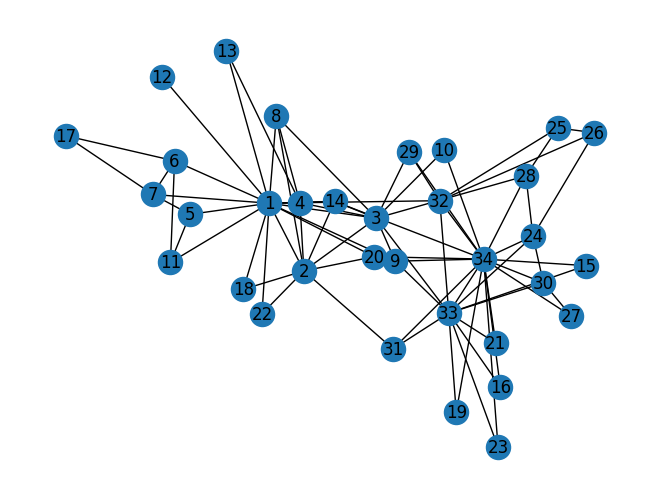

In [123]:
pos = nx.spring_layout(G, seed=4)
nx.draw(G, pos, with_labels=True)
plt.show()

In [128]:
v1 = model.wv.get_vector('25')
v2 = model.wv.get_vector('12')

In [129]:
from scipy import spatial
def cos_similarity(v1, v2):
    return 1 - spatial.distance.cosine(v1, v2)

In [130]:
cos_similarity(v1, v2)

0.3249107301235199

# Node Embedding 聚类

In [135]:
from sklearn.cluster import KMeans
import numpy as np

X = model.wv.vectors
cluster_labels = KMeans(n_clusters=3, n_init='auto').fit(X).labels_

In [136]:
cluster_labels

array([1, 2, 1, 2, 1, 1, 0, 1, 2, 0, 0, 2, 1, 1, 2, 1, 0, 1, 1, 1, 2, 2,
       2, 2, 1, 1, 1, 0, 2, 2, 2, 1, 1, 1])

# 对应

In [137]:
colors = []
nodes = list(G.nodes)
for node in nodes:
    idx = model.wv.key_to_index[str(node)]
    colors.append(cluster_labels[idx])

In [138]:
colors

[1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 0,
 0,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 2]

# 可视化结果

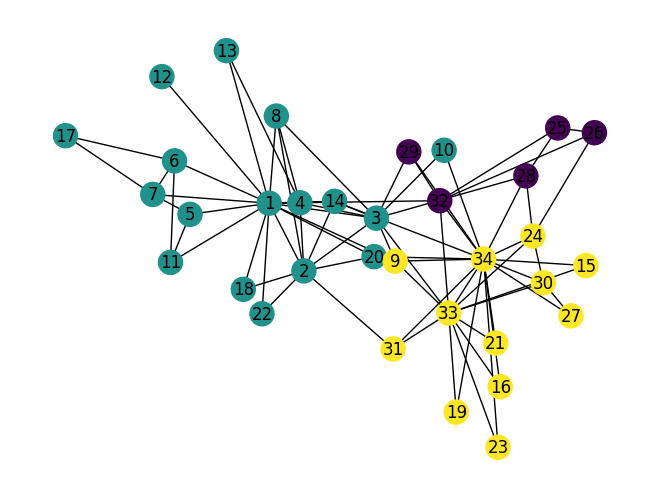

In [140]:
pos = nx.spring_layout(G, seed=4)
nx.draw(G, pos, node_color=colors, with_labels=True)
plt.show()